In [23]:
#Importing packages
from transformers import ViTModel, ViTImageProcessor
import torch
from torch.utils.data import DataLoader
import gc
import pandas as pd
import numpy as np
import chromadb
import matplotlib.pyplot as plt
import numpy as np

#Import library code
import dataloading
import model_functions
import data_vis

In [2]:
labels_csv = "camera_data/coronado_hills_binary_10-24-2025.csv"
image_dir = "camera_data/images/"

data = dataloading.get_data(labels_csv=labels_csv, image_dir=image_dir)

In [3]:
train, val, test = dataloading.get_train_val_test(data = data, output_csvs=True)

In [4]:
persist_directory = "embedding_data/" 
client = chromadb.PersistentClient(path=persist_directory)
collection = client.get_or_create_collection(name="10-27-25_model_embeddings")

In [5]:
db_output = collection.get(ids = val['annotation_id'].astype(str).tolist(), include = ['embeddings'])
embeddings = db_output['embeddings']
labels = val['label']

In [6]:
db_df = pd.DataFrame(embeddings)
db_df['ids'] = db_output['ids']
db_df['ids'] = db_df['ids'].astype('int64')

In [7]:
db_df = db_df.merge(val, left_on = 'ids', right_on='annotation_id')

In [8]:
embeddings = db_df.filter(items = range(0, 768))
labels = db_df['label']
img_urls = db_df['img_url']
a_ids = db_df['annotation_id']

In [9]:
reduced_embeddings, labels = model_functions.reduce_pca(embeddings, labels)

In [10]:
data_vis.save_embeddings_to_json(reduced_embeddings, labels, img_urls, a_ids)

saved embeddings to embedding_data/d3_data.json!


In [29]:
df = pd.DataFrame({
    "x": reduced_embeddings[:,0],
    "y": reduced_embeddings[:,1],
    "label": labels,
    "a_id": val['annotation_id'] 
})

color_map = {0: 'purple', 1: 'gold'}
df['color'] = df['label'].map(color_map)

X = df['x'].values
y = df['label'].values
ids = df['a_id'].values

# find best threshold for desicion stump on x-axis

thresholds = np.unique(X)
best_acc = 0
best_thresh = None
likely_mislabeled = []

for t in thresholds:

    pred1 = (X >= t).astype(int) 
    pred2 = (X < t).astype(int)

    acc1 = (pred1 == y).mean()
    acc2 = (pred2 == y).mean()

    if acc1 > best_acc:
        best_acc = acc1
        best_thresh = t
        likely_mislabeled = ids[pred1 != y]
    if acc2 > best_acc:
        best_acc = acc2
        best_thresh = t
        likley_mislabeled = ids[pred2 != y]

print(f"best threshold: {best_thresh}, accuracy: {best_acc:.3f}")
print("likley mislabeled points:", likley_mislabeled)

best threshold: -4.193141096246097, accuracy: 0.876
likley mislabeled points: [37030 32059 37310 37896 37788 34475 39237 32419 37862 38075 39332 34658
 39708 35055 37604 37817 35229 35104 33942 32178 39869 33620 36577 36945
 35346 32957 37095 34135 36414 33808 34612 37975 38362 36594 37438 33802
 37350 36704 38332 31948 40691 36875 33764 37105 32619 33587 33328 34436
 32374 34075 37687 40628 31702 35191 37012 34043 34921 39278 35149 39746
 37197 33961 37829 40439 37022 39396 32263 32089 32182 34457 38162 40182
 35308 38266 34432 34301 32336 39632 37601 34590 34939 32245 39700 37626
 39264 33995 40675 36914 40197 36695 37158 36591 38369 37543 34878 40770
 37940 38374 33053 32885 39500 40069 36457 33693 34625 38308 37676 34683
 38397 34276 35208 31940 36644 34733 37836 37814 33615 33536 36971 35190
 39445 34695 36928 33372 32241 40834 40210 34575 32320 40655 40707 40387
 40067 38419 40924 32043 32571 34822 34687 34347 36733 36760 33401 39335
 31775 34144 37109 40850 39951 34680 40293 352

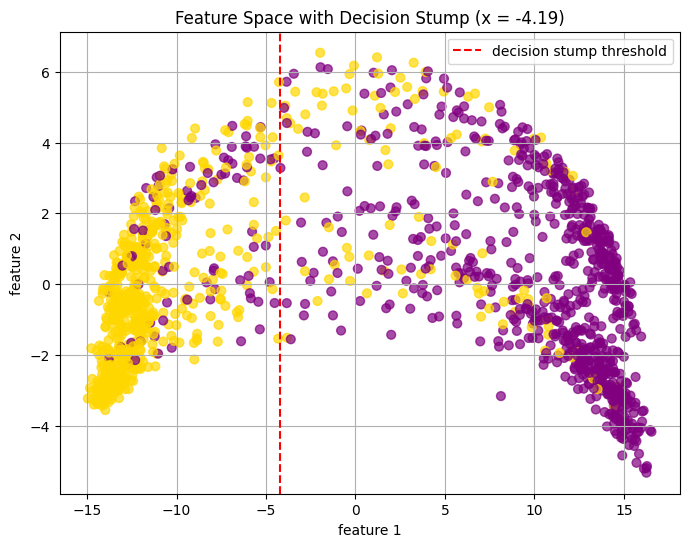

In [28]:
plt.figure(figsize=(8,6))
plt.scatter(df['x'], df['y'], c=df['color'], s=40, alpha=0.7)
plt.axvline(best_thresh, color='red', linestyle='--', label='decision stump threshold')
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.title(f"Feature Space with Decision Stump (x = {best_thresh:.2f})")
plt.legend()
plt.grid(True)
plt.show()


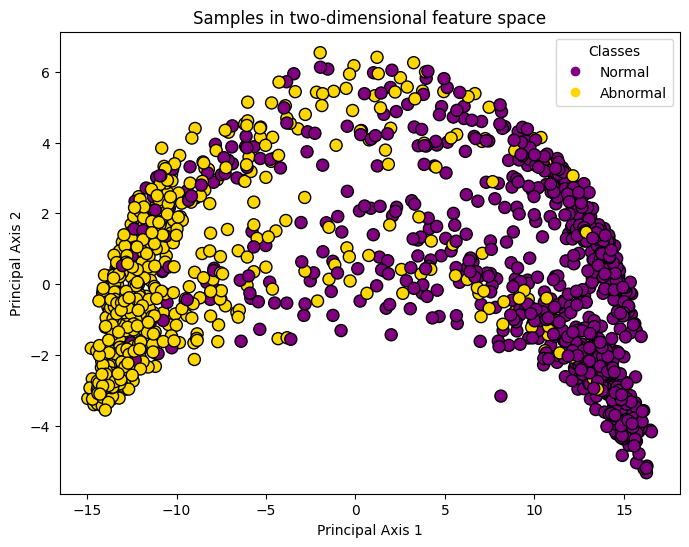

In [11]:
data_vis.plot_data(reduced_embeddings, labels)

Accuracy: 0.8731642189586115


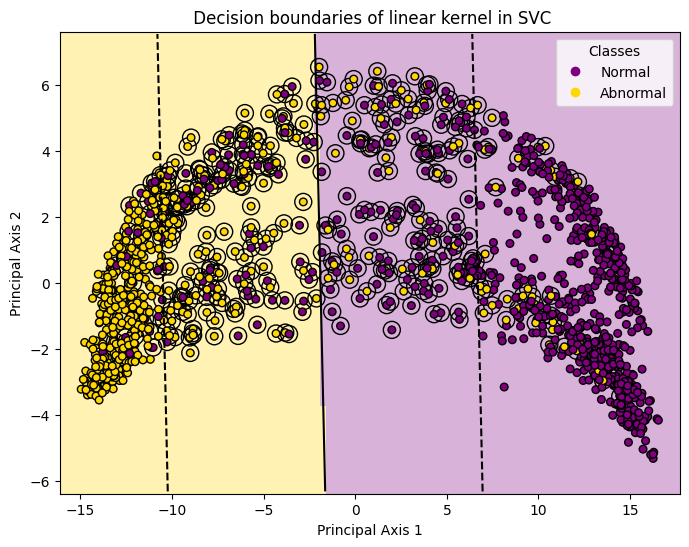

In [12]:
svm_classifier = data_vis.plot_with_decision_boundary("linear", reduced_embeddings, labels)

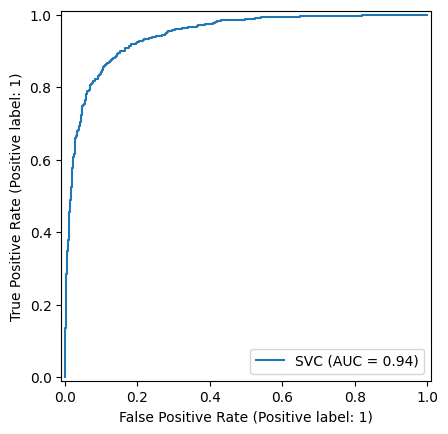

In [13]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

RocCurveDisplay.from_estimator(
   svm_classifier, reduced_embeddings, labels)

plt.show()